In [13]:
# import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
                            accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

import warnings 
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# read in csv

df = pd.read_csv('/Users/juhee/Desktop/GA/lsmtmp/juhee/data/final_labeled.csv')

print(df.shape)
df.head()

(38325, 10)


,id,user_name,lat,long,date,text,text_clean,n_sentence,n_words,label
0,1241152458912673794,DarkDon_,40.738154,-112.101609,2020-03-20 23:59:40+00:00,TK Kirkland's Reaction To Earthquake's Ex-Wife...,tk kirkland s reaction to earthquake ex wife o...,1,17,1
1,1241152416214474753,ReallyInID,42.242918,-112.103304,2020-03-20 23:59:30+00:00,That sound you hear is NOT an earthquake. It’s...,that sound you hear is not an earthquake it s...,2,13,1
2,1241152284827856896,folsworth,40.982162,-112.104020,2020-03-20 23:58:58+00:00,he said he stocked up on ammo cause he knew Th...,he said stocked up on ammo cause knew the big ...,2,23,1
3,1241152178695405570,Colony14,42.729481,-112.107004,2020-03-20 23:58:33+00:00,"If an earthquake separates CA, WA, and OR from...",if an earthquake separate ca wa and or from t...,1,23,1
4,1241152072818364416,MonitorSismico,41.044996,-112.103864,2020-03-20 23:58:08+00:00,"#Sismo M 4 SOUTH OF BALI, #INDONESIA. 20-03-20...",sismo m south of bali indonesia utc http...,2,13,1


In [3]:
# set up X and y and train test split

X = df['text_clean']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 42, stratify = y)

In [4]:
## please swap out relevant words for your disaster accordingly here
# create a custom stop words list

relevant_words = ['earthquake']

print(len(stopwords.words('english')))

stop_words = stopwords.words('english') + relevant_words

print(len(stop_words))

179
180


In [5]:
# pipline for the model

pipe_svc = Pipeline([
                     ('tvec', TfidfVectorizer(max_features = 4000, stop_words = stop_words, max_df = 0.85, min_df = 0.002, ngram_range = (1, 2))),
                     ('svc', SVC(probability = True))
                    ])

In [6]:
# fit the training set

pipe_svc.fit(X_train, y_train)

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.85, max_features=4000, min_df=0.002,
                                 ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('svc', SVC(probability=True))])

In [7]:
# predictions

y_preds = pipe_svc.predict(X_test)

# score

accuracy_score(y_test, y_preds)

0.8870177103099304

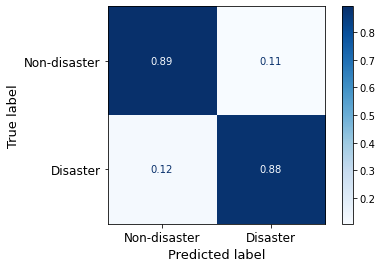

In [8]:
# confusion matrix values

tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()

# view confusion matrix

labels = ['Non-disaster','Disaster']
plot_confusion_matrix(pipe_svc, X_test, y_test, cmap = 'Blues', normalize = 'true')
plt.xticks(ticks = [0, 1], labels = labels, size = 12)
plt.yticks(ticks = [0, 1], labels = labels, size = 12)
plt.xlabel('Predicted label', size = 13)
plt.ylabel('True label', size = 13);
plt.savefig('../images/confusion_matrix.png'); 

In [16]:
roc_auc_score(y_test, pred_proba)

0.9425046271748534

In [11]:
pred_proba = [i[1] for i in pipe_svc.predict_proba(X_test)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

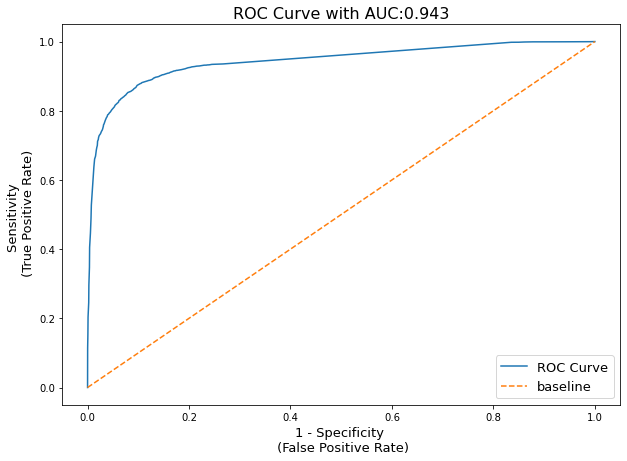

In [24]:
# create figure

plt.figure(figsize = (10,7))

# create threshold values (dashed orange line)

thresholds = np.linspace(0, 1, 200)

# define function to calculate sensitivity (true positive rate)

def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# define function to calculate false positive rate (1 - specificity)

def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# calculate sensitivity & 1-specificity for each threshold between 0 and 1

tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# plot roc curve

plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label = 'ROC Curve')

# plot baseline

plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label = 'baseline',
         linestyle = '--')

# label axes

plt.title('ROC Curve with AUC:' + round(roc_auc_score(pred_df['true_values'], pred_df['pred_probs']), 3).astype(str), fontsize = 16)
plt.ylabel('Sensitivity \n (True Positive Rate)', fontsize = 13)
plt.xlabel('1 - Specificity \n (False Positive Rate)', fontsize = 13)

# legend

plt.legend(fontsize = 13)

plt.savefig('../images/roc_curve.png');